Diffusion models aim to improve generative abilities of GANs. They incorporate different architecture although, just like GANs, it also bases off learning on the noise component that is also generated using Gaussians.

Diffusion models are trying to noise out the image by passing it through some filter $t$ times and then recursively pass the noise through the neural net to get back each $t-1$ step that is leading up to the original image.

#### Main network ideas
* Forward pass: $q(x_t|x_{t-1})$: we apply some noise over timestep $t$, which we can do with a reparameterization trick preliminary initializing $\beta_t$ (noise schedule) for each timestep, that is deciding the $\mu$ and $\sigma$ of the new gaussian applied to the image. There are several approaches to creating $\beta$: linear (introduced in the original [DDPM paper](https://arxiv.org/pdf/2006.11239)) and the sinusoidal (proposed in openAI)
* Backward pass: $p(x_{t-1}|x_{t})$: learning the reverse "denoising" process that is based on the encoded timestep $t$ and the image itself. Realistically, we're adjusting "noise parameters", therefore the model learns the noise rather than the image representation itself.

#### FID score
Just like any generative models, apart from the MSE metric to compare output pixles with the original image we can also use a metrics that is specifically designed for generative models, that is the [FID score](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance), that is based on a metric designed to compare two multivariate Gaussians:
$$
d^2=|\mu_X-\mu_Y|^2+tr(\Sigma_X+\Sigma_Y-2(\Sigma_X\Sigma_Y)^{1/2})
$$

In [1]:
import torch
from tqdm import tqdm

class Diffusion():

    def __init__(self, noise_steps=1000,
                 beta_start=1e-4,
                 beta_end=.02,
                 img_size=64,
                 device='cuda',
                 *args, **kwargs) -> None:
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        self.beta = self.prep_noise_schedule().to(device)

        # we re-denote betas as alphas to account for the
        # reparametrization trick
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def prep_noise_schedule(self):
        """ 
        Classic DDPM linear scheduling
        """
        return torch.linspace(self.beta_start,self.beta_end,self.noise_steps)
    
    def noise_image(self, x, t):
        # span over 3 RGB channels
        # we also dont have to sample noise sequentially
        # and are able to do it in one go, by just referring to
        # the timestep t
        sqrt_bar_alpha = ((self.alpha_bar[t])**.5)[:, None, None, None]

        one_sub_bar_alpha = ((1-self.alpha_bar[t])**.5)[:, None, None, None]  

        # torch.randn_like(input) is equivalent to torch.randn(input.size(),
        # dtype=input.dtype, layout=input.layout, device=input.device).
        # where layout is defined by the tensor either being COO (sparse)
        # or just the regular type
        return sqrt_bar_alpha * x + one_sub_bar_alpha * torch.rand_like(x), torch.rand_like(x)
    
    def sample_timesteps(self, n):
        return torch.randint(1, self.noise_steps, (n, ))
    
    def sample(self, model, n):
        """
        DDPM paper algorithm #2: Reverse sampling back from
        x_t to x_0
        """
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device) # convert to int64
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.rand_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - (1-alpha) /\
                        torch.sqrt(1-alpha_bar) * predicted_noise) + \
                        torch.sqrt(beta) + noise
        model.train()
        x = (x.clamp(-1,1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

#### Unets
For generating images we can use simple autoencoders, but a more applicable architecture is the Unet. It works as an AE, but uses additional skip connections (concatenations/merges) with hidden layers of the encoder part of the AE:

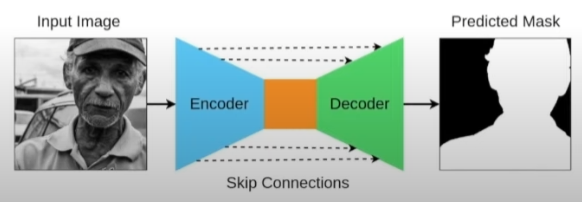

Before coding up the actual UNet, it's important to implement certain modules of it, namely:
* `DoubleConv`: module consisting of two CNNs, activation and a groupnorm in-between
    * `GroupNorm`: a module that in the scope of convolution normalizes values across channels (every image feature). Other normalization techniques, like LayerNorm does not account, hence this method is more applicable in CV NNs. Pytorch implementation takes group size (how many features are grouped together) as the **first argument** and evenly distributed in order to contain a total number of channels as the output provided in the **second argument**.

In [2]:
from torch import nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, mid_ch=None, apply_residual_connection=False,
                 *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.apply_residual_connection = apply_residual_connection
        if not mid_ch:
            mid_ch = out_ch
        self.double_conv = nn.Sequential(
            # set bias to false to save computational power,
            # because the GroupNorm cancells out this term
            # upon applying it to WX+B
            nn.Conv2d(in_ch, mid_ch, 3, padding=1, bias=False),
            nn.GroupNorm(1, mid_ch),
            nn.GELU(),
            nn.Conv2d(mid_ch, out_ch, 3, padding=1, bias=False),
            nn.GroupNorm(1, out_ch)
        )
    def forward(self, x):
        if self.apply_residual_connection:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

* `DownSampler`: a module that is at the backbone of the encoder block of the Unet. It pools input image to reduce its size by the factor of 2 using MaxPooling. Inside of it an embedding for the timestep is also summed with the "embedding of the image", just like in the Transformer

In [3]:
class DownSampler(nn.Module):

    def __init__(self, in_ch, out_ch, emb_dims=128, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch,in_ch,apply_residual_connection=True),
            DoubleConv(in_ch,out_ch)
        )
        self.pos_embed = nn.Sequential(
            # SiLU is better that ReLU, both computationally and learning-wise,
            # and is more commonly used in CV problems than GELU when it comes to
            # learning positional embeddings
            nn.SiLU(),
            nn.Linear(emb_dims,out_ch)
        )

    def forward(self, x, t):
        emb = self.maxpool_conv(x)
        h, w = emb.shape[-2], emb.shape[-1]
        # expanding dimensions to 2d
        posemb = self.pos_embed(t)[:,:,None,None].repeat(1,1,h,w)
        return emb + posemb

* `UpSampler`: a module that reverses downsampling and is working to increase the number of channels in order to match the original image. The backbone of this module is the PyTorch Upsample module.
    * `Upsample`: torch module, that increases number of channels, as well as pixels on the height and width axises by some scale factor that is passed as the **first argument**. Numbers that are used to fill in the "gaps" left by increased number of dimensions are sampled according to the "mode" chosen as the **second argument**. In this notebook we're using a "bilinear" mode that is using a linear sampling by equal steps-fractions.

In [4]:
class UpSampler(nn.Module):

    def __init__(self, in_ch, out_ch, emb_dims=128, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.up = nn.Upsample(scale_factor=2,mode='bilinear',
                              align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_ch, in_ch, apply_residual_connection=True),
            # we provide middle channels as div by the factor of two
            # in order to account for a concatenation of Encoder and Decoder
            DoubleConv(in_ch, out_ch, in_ch // 2)
        )

        self.pos_embed = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dims,out_ch)
        )

    def forward(self, x, skip_x, t):
        """ 
        - x: torch.Tensor
            - noised image
        - skip_x: torch.Tensor
            - noise at T-t step of the encoder
        - t: int
            - timestep t out of T
        """
        x = self.up(x)
        x = torch.cat([
            skip_x, x
        ], dim=1)
        x = self.conv(x)
        h, w = x.shape[-2], x.shape[-1]
        posemb = self.pos_embed(t)[:,:,None,None].repeat(1,1,h,w)
        return x + posemb

* `SelfAtt`: a classic self-attention module that has been implemented in Transformers. In particular, this module is going to use torch's MHA for attention mechanism, custom implementation of which can be found in `./mha_classifier.ipynb`

In [5]:
class selfAtt(nn.Module):

    def __init__(self, ch_in, size, 
                 num_heads=4, dropout=.2,
                  multiplier=2, *args, **kwargs) -> None:
        """ 
        - ch_in: int
            - number of input channels
        - size: int
            - number of pixels on h/w axes
        - num_heads: int
            - number of K,Q heads for the MHA
        """
        super().__init__(*args, **kwargs)
        self.ch_in = ch_in
        self.size = size
        self.mha = nn.MultiheadAttention(
            embed_dim=ch_in,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.ln = nn.LayerNorm([ch_in])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([ch_in]),
            nn.Linear(ch_in, ch_in*multiplier),
            nn.GELU(),
            nn.Linear(ch_in*multiplier, ch_in),
        )

    def forward(self, x):
        # reshape to match the expected shape for the attention
        # (in NLP that would be max_seq x embed_dims)
        x = x.view(-1, self.ch_in, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.ch_in, self.size, self.size)

Finally all of those 4 modules make up for the Unet architecture:

In [6]:
class UNet(nn.Module):

    def __init__(self, ch_in=3, ch_out=3, time_dims=128, device='cuda',
                  *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.device = device
        self.time_dims = time_dims

        # ENCODER
        self.conv1 = DoubleConv(ch_in, 64)
        # slashing features by 2 by taking window size
        # twice as large
        self.down1 = DownSampler(64, 128) 
        self.att1 = selfAtt(128, 32) 
        self.down2 = DownSampler(128, 256)
        self.att2 = selfAtt(256, 16)
        self.down3 = DownSampler(256, 256)
        self.att3 = selfAtt(256, 8)

        # BOTTLENECK layers, that are not concatenated
        # with the decoder part of the UNet
        self.bottl1 = DoubleConv(256, 512)
        self.bottl2 = DoubleConv(512, 512)
        self.bottl3 = DoubleConv(512, 256)

        # DECODER
        self.up1 = UpSampler(512, 128) 
        self.att4 = selfAtt(128, 16) 
        self.up2 = UpSampler(256, 64)
        self.att5 = selfAtt(64, 32)
        self.up3 = UpSampler(128, 64)
        self.att6 = selfAtt(64, 64)
        self.convOut = nn.Conv2d(64, ch_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        """ 
        Sinusoidal positional encoding for each timestep t
        """
        inv_freq = 1.0 / (
            10_000 ** (torch.arange(0, channels, 2, device=self.device).float() /\
                       channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([
            pos_enc_a, pos_enc_b
        ], dim=-1)
        return pos_enc
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)

        # returns tensor of size t.shape[0] x t_dims
        t = self.pos_encoding(t, self.time_dims) 
        
        x1 = self.conv1(x) 
        x2 = self.down1(x1, t)
        x2 = self.att1(x2)
        x3 = self.down2(x2, t)
        x3 = self.att2(x3)
        x4 = self.down3(x3, t)
        x4 = self.att3(x4)

        x4 = self.bottl1(x4)
        x4 = self.bottl2(x4)
        x4 = self.bottl3(x4)

        x = self.up1(x4, x3, t)
        x = self.att4(x)
        x = self.up2(x, x2, t)
        x = self.att5(x)
        x = self.up3(x, x1, t)
        x = self.att6(x)

        return self.convOut(x)

Once we're ready with the Unet as well as the Diffusion model itself we can start prepping all utility functions that are going to come in handy later. 
* `plot_images()`: plots images. For a classical 3-channel image, resize operations might not make sense at first glance. They are vital if we want to plot them using pyton libraries and, thus, it is important to undertand them. Hence, I've made a detailed visual diagram of how these transformations work in order to bring image from model-friendly representation of $C\times H\times W$, where we treat each channel as a separate feature, to a pixel-wise representation of $H\times W\times C$, where we treat each image as a set of vectors, consisting of RGB values:
    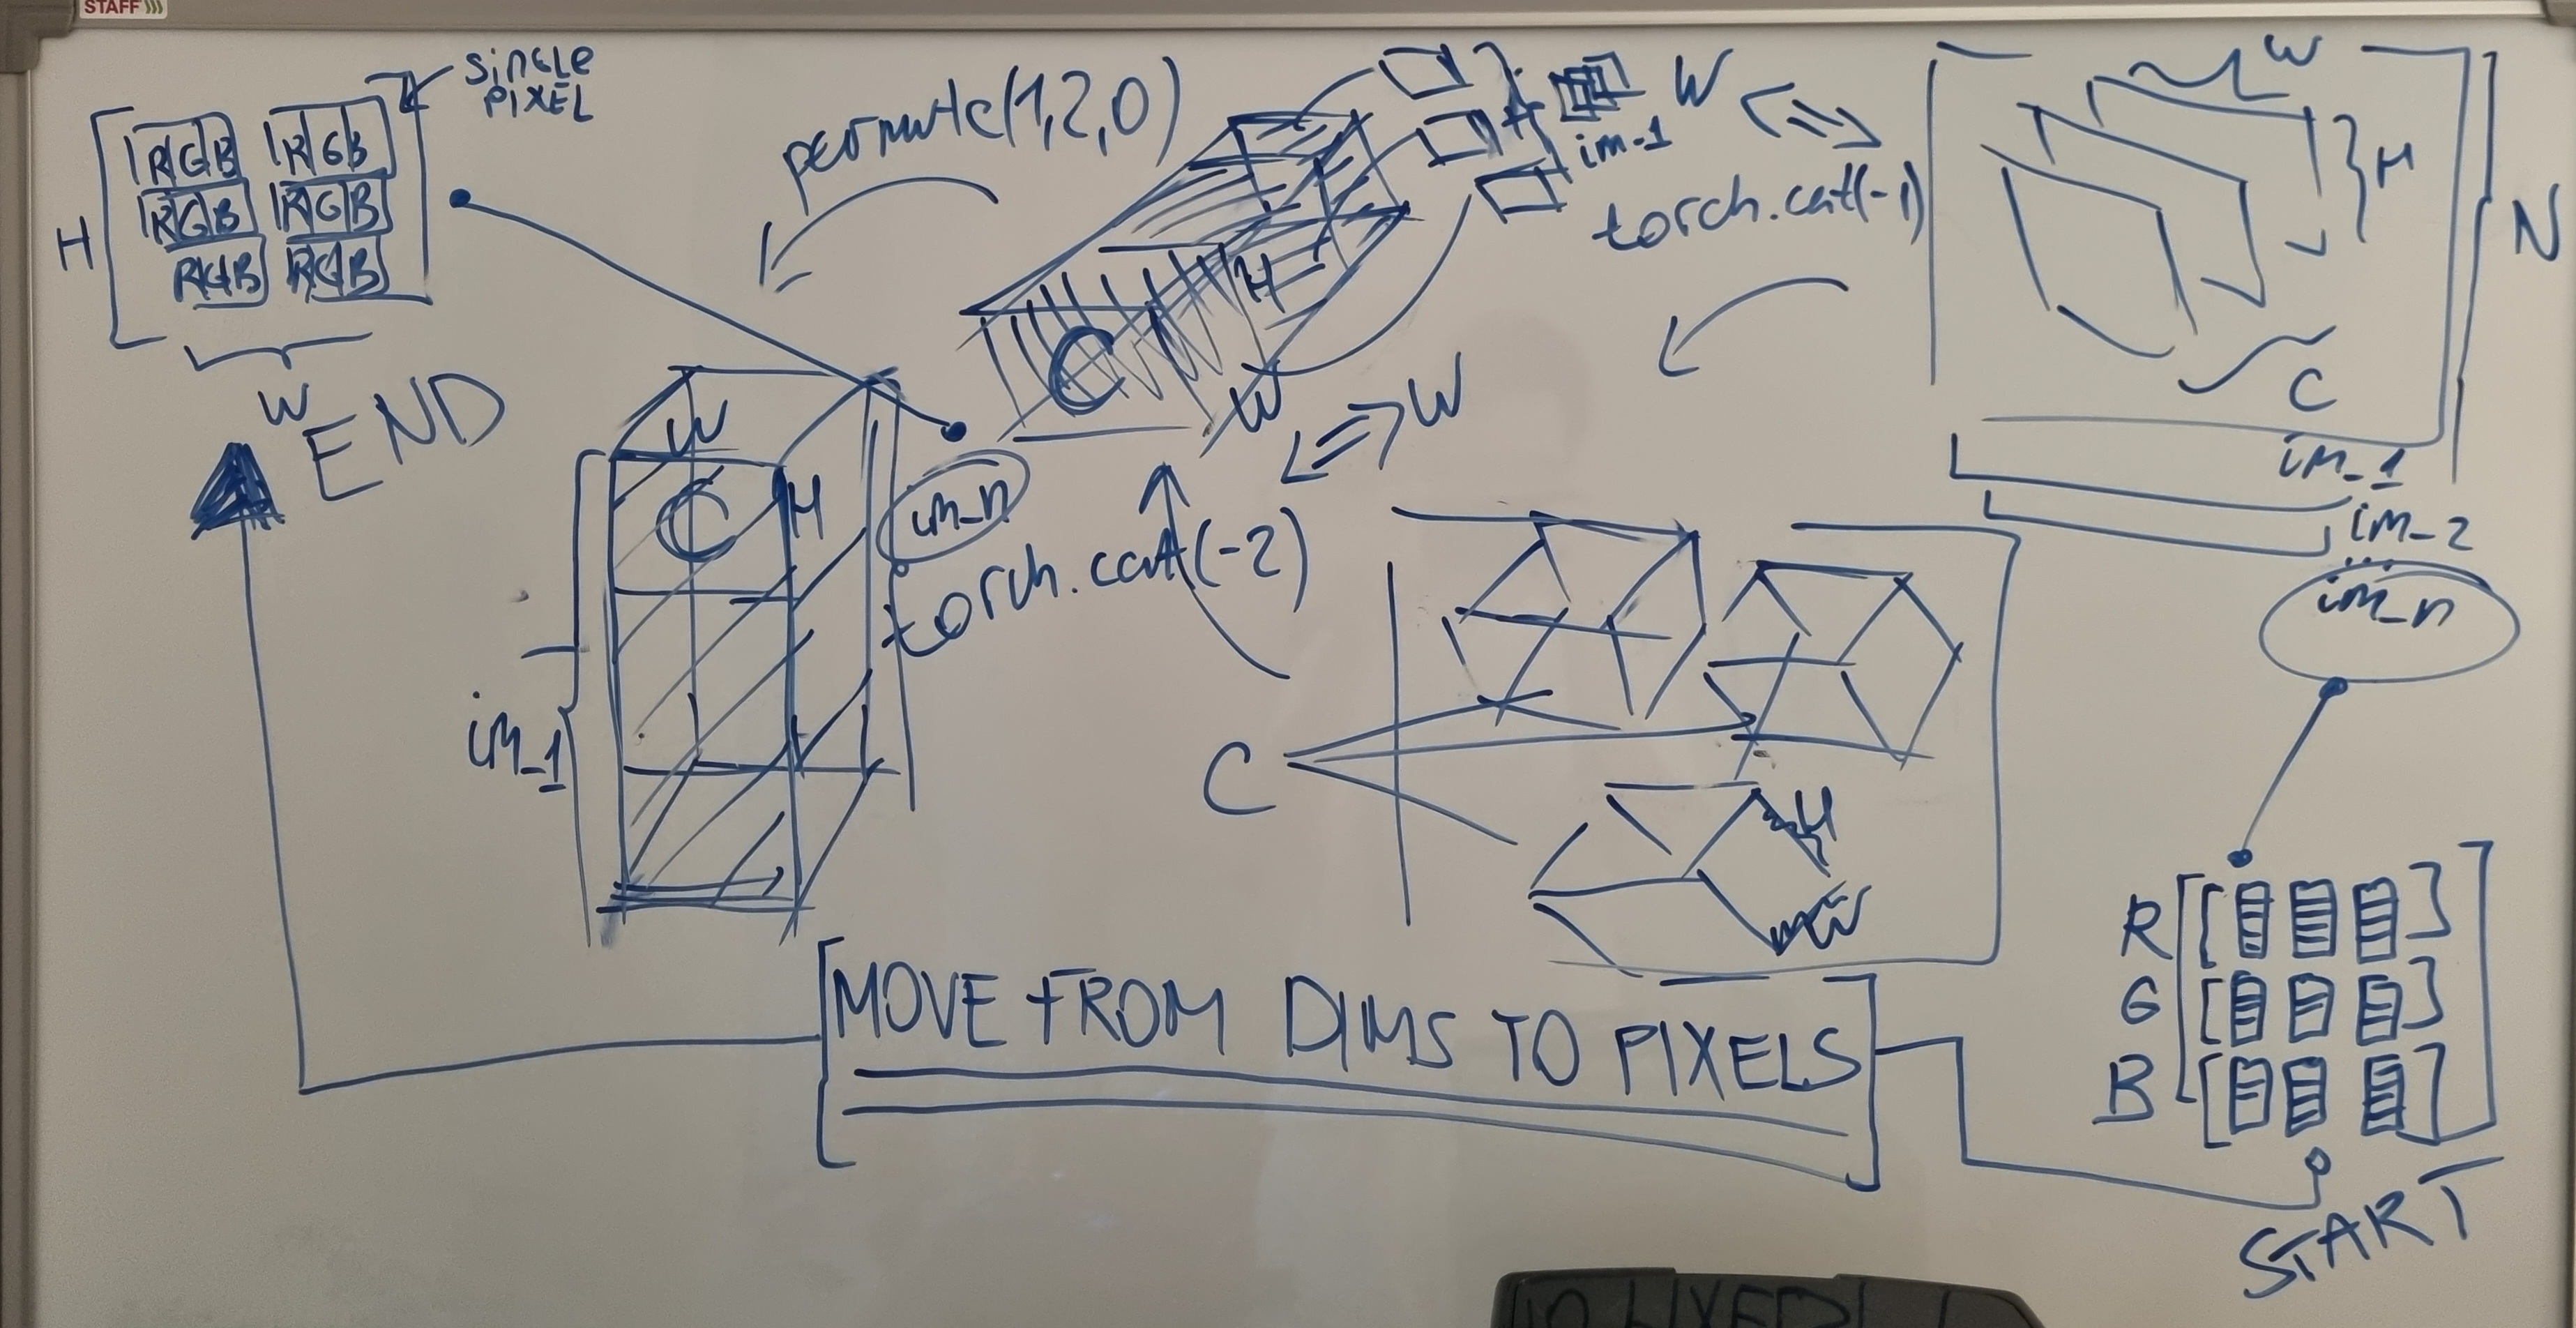

* `get_data()`: applies transformations to images and returns the dataloader for the training loop
* `create_checkpoint()`: creates a seperate checkpoint-directory for saving model's weights as well as its metric results

In [7]:
import torchvision
import os
import logging
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def plot_images(images, k=10):
    # randomly sampling K images
    generated_sample = torch.randperm(images.shape[0])[:k]
    images = images[generated_sample].cpu()

    # transforming from dimension-wise to pixel-wise
    # (transformations are explained in the diagram above)
    transformed_images = torch.cat(
        [torch.cat([img for img in images], dims=-1)], 
    dims=-2).permute(1,2,0)

    plt.figure(figsize=(32,32))
    plt.imshow(transformed_images)
    plt.show()

def get_data(args):
    channel_means = (.5,.5,.5)
    channel_stds = (.5,.5,.5)

    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(80),
        torchvision.transforms.RandomResizedCrop(
            args['img_size'], scale=(.8, 1.0)),

        # ToTensor scales [0,255] to [0, 1] and shifts shapes images from
        # H x W x C to model-friendly C x H x W
        torchvision.transforms.ToTensor(), 

        # each channel is normalized into [-1;1] range, because
        # z=(x-.5)/.5 for x in [0; 1] will result into [-1; 1]
        torchvision.transforms.Normalize(
            channel_means, channel_stds)
    ])
    dataset = torchvision.datasets.CIFAR10(
        root='./data/vision',
        train=True,
        transform=transforms,
        download=True)
    dataloader = DataLoader(dataset, batch_size=args['batch_size'], shuffle=True)
    return dataloader

def create_checkpoint(run_name, base_dir):
    models_dir = os.path.join(base_dir,'models')
    results_dir = os.path.join(base_dir,'results')
    rundir_m, rundir_r = os.path.join(models_dir, run_name), \
        os.path.join(results_dir, run_name)

    # exist_ok=True argument skips derictory's creation
    # if it already exists. Otherwise, it raises an error
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    
    os.makedirs(rundir_m, exist_ok=True)
    os.makedirs(rundir_r, exist_ok=True)

    return rundir_m, rundir_r

After preparing a couple of utility scripts we're ready to finally setup the training loop:

In [8]:
training_args = {
    'run_name': 'diffuse',
    'base_dir': './runs/cv/',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'lr': .0001,
    'patience': 10,
    'img_size': 64,
    'max_epochs': 200,
    'batch_size': 2,
    'verbose_level': 10,
}

In [9]:
from torch import optim
from torch.utils.tensorboard import SummaryWriter

def launch_training(args):
    run_dir, run_dir_res = create_checkpoint(args['run_name'],
                                             args['base_dir'])
    device = args['device']
    dataloader = get_data(args)

    # training modules
    model = UNet().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     patience=args['patience'])
    criterion = nn.MSELoss().to(device)
    diffusion = Diffusion(
        img_size=args['img_size'], device=device
    )

    logger = SummaryWriter(run_dir_res)
    N = len(dataloader)
    av_MSEs = []

    for epoch in range(args['max_epochs']):
        pbar = tqdm(dataloader)
        MSEs = []

        for i, (images, _) in enumerate(pbar):
            optimizer.zero_grad()
            images = images.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_image(images, t)
            predicted_noise = model(x_t, t)
            loss = criterion(noise, predicted_noise)
            scheduler.step(loss)
            loss.backward()
            optimizer.step()

            # add text to the tqdm pbar
            pbar.set_postfix(MSE=loss.item())
            
            MSEs.append(loss.detach().cpu())
            logger.add_scalar('MSE', loss.item(), global_step=epoch*N+i)
        
        av_MSEs.append(torch.hstack(MSEs).mean().item())

        if epoch % args['verbose_level'] == 0:
            logging.info(f'Epoch: {epoch+1} :: av MSE: {av_MSEs[-1]}')
            torch.save(model.state_dict(), os.path.join(run_dir,
                                        'diffusion_ckpt.pt'))
            sampled_images = diffusion.sample(model, n=images.shape[0])
            plot_images(sampled_images)


In [ ]:
launch_training(training_args)

In [ ]:
torch.cuda.empty_cache()
model = UNet().to(training_args['device'])
model.load_state_dict(torch.load('./runs/cv/models/diffuse/diffusion_ckpt.pt'))
diffusion = Diffusion(
    img_size=training_args['img_size'], device=training_args['device']
)
sampled_images = diffusion.sample(model, n=20)
plot_images(sampled_images)